In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

## Combine data frames

In [2]:
def sanity_check(df):
    print df.shape
    print "num formulas: %d" % (df.shape[0] / 21)
    print "parity: %d" % (df.shape[0] % 21)

In [3]:
dfa = pd.read_csv('joined15.csv')
dfb = pd.read_csv('joined1617.csv')
sanity_check(dfa)
sanity_check(dfb)

(861, 15)
num formulas: 41
parity: 0
(441, 15)
num formulas: 21
parity: 0


In [4]:
df = dfa.append(dfb, ignore_index=True)
sanity_check(df)

(1302, 15)
num formulas: 62
parity: 0


In [5]:
df[df.duplicated(subset=['experiment','solver', 'formula'])]

,experiment,solver,formula,variables,clauses,runtime,conflicts,decisions,restarts,propagations,entropy,backbone,num_sols,chi_square,cpu_time


No duplicated formulas from 15,16,17 competitions

## Load data frame
### Perform data preperation

In [6]:
df.head()

,experiment,solver,formula,variables,clauses,runtime,conflicts,decisions,restarts,propagations,entropy,backbone,num_sols,chi_square,cpu_time
0,exp2,COMiniSatPS-6,40bits_10.dimacs.cnf,446,12980,61.07870,224458,255797,475.0,16165613,0.130045,0.869955,2.0,0.0,4.79127
1,exp2,COMiniSatPS-5,40bits_10.dimacs.cnf,446,12980,36.70640,234944,274595,367.0,14949163,0.130045,0.869955,2.0,0.0,4.79127
2,exp5,wrapper-60,40bits_10.dimacs.cnf,446,12980,15.73160,117363,154663,356.0,4992154,0.130045,0.869955,2.0,0.0,4.79127
3,exp4,wrapper-glucose,40bits_10.dimacs.cnf,446,12980,2.13967,26069,32948,64.0,979665,0.130045,0.869955,2.0,0.0,4.79127
4,exp2,COMiniSatPS-4,40bits_10.dimacs.cnf,446,12980,48.07070,222780,258214,319.0,15949794,0.130045,0.869955,2.0,0.0,4.79127


In [7]:
# timeout formulas (for Oh's experiments)
df[df['variables'] == 0]

,experiment,solver,formula,variables,clauses,runtime,conflicts,decisions,restarts,propagations,entropy,backbone,num_sols,chi_square,cpu_time
637,exp2,COMiniSatPS-5,aes_32_3_keyfind_1.cnf,0,0,0.0,0,0,0.0,0,0.0,1.0,1.0,0.0,2709.81
638,exp2,COMiniSatPS-6,aes_32_3_keyfind_1.cnf,0,0,0.0,0,0,0.0,0,0.0,1.0,1.0,0.0,2709.81
647,exp2,COMiniSatPS-4,aes_32_3_keyfind_1.cnf,0,0,0.0,0,0,0.0,0,0.0,1.0,1.0,0.0,2709.81
1265,exp2,COMiniSatPS-6,aes_32_3_keyfind_2.cnf,0,0,0.0,0,0,0.0,0,0.0,1.0,1.0,0.0,1973.15


In [8]:
# find timeout formulas
terminated_formulas = set()
terminated_indices = list() 
for index, row in df[df['variables'] <= 0].iterrows():
    terminated_formulas.add(row['formula'])
    terminated_indices.append(index)

print terminated_formulas
print terminated_indices

set(['aes_32_3_keyfind_2.cnf', 'aes_32_3_keyfind_1.cnf'])
[637, 638, 647, 1265]


#### find all terminated indices (for all other experiments too), or should we just delete those rows?

In [9]:
#df.drop(terminated_indices, inplace=True)
#sanity_check(df)

will delete them below

### Check formulas runtime statistics across all engines

In [10]:
means = df.groupby('formula')['runtime'].mean()
medians = df.groupby('formula')['runtime'].median()
stds = df.groupby('formula')['runtime'].std()
series_list = [means, medians, stds]
statsdf = pd.concat(series_list, axis=1)
statsdf.columns=['mean', 'median', 'std']
statsdf.sort_values('mean')

,mean,median,std
formula,,,
mrpp_4x4#4_5.cnf,0.015046,0.010998,0.019999
C168_FW_UT_518.cnf,0.016331,0.014997,0.020836
manthey_single-ordered-initialized-w12-b6.cnf,0.018950,0.013997,0.027491
manthey_single-ordered-initialized-w14-b7.cnf,0.027568,0.026995,0.026170
e2a_2.c.smt2-cvc4.cnf,0.110799,0.092985,0.139002
manthey_single-ordered-initialized-w20-b10.cnf,0.129845,0.085986,0.143185
e2_2.c.smt2-cvc4.cnf,0.142892,0.091986,0.171836
mrpp_4x4#8_8.cnf,0.157313,0.157975,0.077611
mrpp_6x6#10_8.cnf,0.291397,0.223965,0.211190


### Remove formulas with runtime mean and std < 1 second (and terminated formulas too)

In [11]:
formulas_to_remove = list(statsdf[(statsdf['mean'] < 1) & (statsdf['std'] < 1)].index)
formulas_to_remove += list(terminated_formulas)
print('formulas_to_remove', len(formulas_to_remove))
print('expected #rows', len(formulas_to_remove)*21)
indices = list()
for index, row in df.iterrows():
    if row['formula'] in formulas_to_remove:
        indices.append(index)
print(len(indices))
print('before ', df.shape)
df.drop(indices, inplace=True)
print('after ', df.shape)

('formulas_to_remove', 14)
('expected #rows', 294)
294
('before ', (1302, 15))
('after ', (1008, 15))


In [12]:
sanity_check(df)

(1008, 15)
num formulas: 48
parity: 0


## Add solution density

In [13]:
df['solution_density'] = df.apply(lambda x: (math.log(x['num_sols'], 2) / x['variables']), axis=1)

## Number of unique formulas

In [14]:
formulas_set = set()
for index, row in df.iterrows():
    formulas_set.add(row['formula'])

print(len(formulas_set))

48


# Helpers for experiments

In [15]:
def create_secondary_dataframe(df, exp, formulas_set, a_val, b_val):
    """
        Creates a secondary data frame for checking runtime diffs
        columns = ['formula', 'entropy', 'solution_density', 'backbone', 'diff']
        a_val and b_val are the actual solvers
        diff is a_runtime - b_runtime
    """
    # get experiment
    exp_df = df[df['experiment'] == exp]
    # create df
    columns = ['formula', 'entropy', 'solution_density', 'backbone', 'diff']
    out_df = pd.DataFrame(columns=columns)

    for index, f in enumerate(formulas_set):
        # get formula,solver row
        df_a = exp_df[(df['formula'] == f) & (df['solver'] == a_val)]
        df_b = exp_df[(df['formula'] == f) & (df['solver'] == b_val)]
        # should have 1 rows after manipulation
        assert(df_a.shape[0] == 1)
        assert(df_b.shape[0] == 1)

        out_df.loc[index] = [f, 
                              df_a.iloc[0]['entropy'], 
                              #math.log(df_a.iloc[0]['num_sols'], 2) / df_a.iloc[0]['variables'],
                              df_a.iloc[0]['solution_density'],
                              df_a.iloc[0]['backbone'], 
                              df_a.iloc[0]['runtime'] - df_b.iloc[0]['runtime']
                             ]
    return out_df

In [16]:
def plotter(df, exp, formulas_set, a_val, b_val, x_property, x_lim=None, y_lim=None, opts='regression'):
    """
        Plot diff (a_val - b_val) with x as x_property (could be entropy, num_sols, backbone)
    """
    exp_df = create_secondary_dataframe(df, exp, formulas_set, a_val, b_val)
    x = exp_df[x_property]
    y = exp_df['diff']
    # scatter
    plt.plot(x , y, 'ro')
    # regression line
    if opts == 'regression':
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x + b, '-')
    # add lines: distance for x=0
    elif opts == 'lines':
        for index, values in y:
            pass # TODO
    if x_lim:
        plt.xlim(x_lim)
    if y_lim:
        plt.ylim(y_lim)
    plt.xlabel(str(x_property))
    plt.ylabel('Runtime (seconds)')
    title = 'Delta runtime: ' + str(a_val) + '-' + str(b_val)
    plt.title(title)
    plt.show()

In [17]:
def plotter_entropy_sols_sharingy(df, exp, formulas_set, a_val, b_val):
    """
        Two subplots sharing Y
    """
    exp_df = create_secondary_dataframe(df, exp, formulas_set, a_val, b_val)
    y = exp_df['diff']
    
    # config 2 plots
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    # first plot (entropy)
    x = exp_df['entropy']
    ax1.scatter(x, y)
    # add regression line
    m, b = np.polyfit(x, y, 1)
    ax1.plot(x, m*x + b, '-')
    # settings
    ax1.set_xlabel('entropy')
    ax1.set_ylabel('Runtime (seconds)')
    title1 = 'Delta runtime: ' + str(a_val) + '-' + str(b_val)
    ax1.set_title(title1)
    ax1.autoscale_view()
    
    # second plot (density)
    x = exp_df['solution_density']
    ax2.scatter(x, y)
    # add regression line
    m, b = np.polyfit(x, y, 1)
    ax2.plot(x, m*x + b, '-')
    # settings
    ax2.set_xlabel('solution_density')
    ax2.set_ylabel('Runtime (seconds)')
    title2 = 'Delta runtime: ' + str(a_val) + '-' + str(b_val)
    ax2.set_title(title1)
    ax2.autoscale_view()
    
    plt.show()

In [18]:
def entropy_sols_plotter(df, exp, formulas_set, a_val, b_val):
    plotter(df, exp, formulas_set, a_val, b_val, 'entropy', x_lim=(0,df['entropy'].max()))
    plotter(df, exp, formulas_set, a_val, b_val, 'solution_density', x_lim=(0,df['solution_density'].max()))

# Exp1 - Database reduction: (With - Without)

## Plots

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


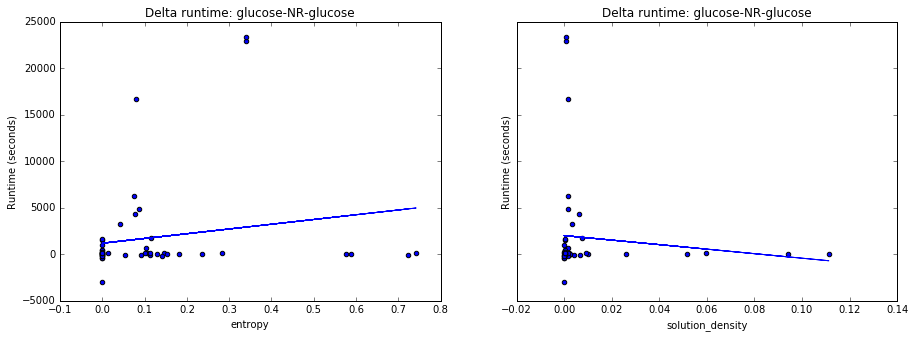

In [19]:
#entropy_sols_plotter(df, 'exp1', formulas_set, 'glucose-NR', 'glucose')
plotter_entropy_sols_sharingy(df, 'exp1', formulas_set, 'glucose-NR', 'glucose')

There's high variation with low entropy (and low density), and it stabilizes as entropy increases.

# Exp2: Controlling lbd-cut (LBD1 - LBD5)

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


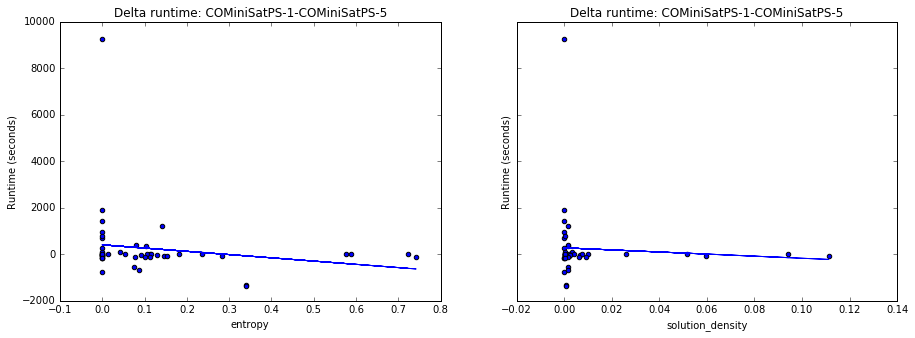

In [20]:
plotter_entropy_sols_sharingy(df, 'exp2', formulas_set, 'COMiniSatPS-1', 'COMiniSatPS-5')

Entropy trend same as our paper, about solution density we can tell there's high variation in low density formulas.

## LBD0 - LBD5

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


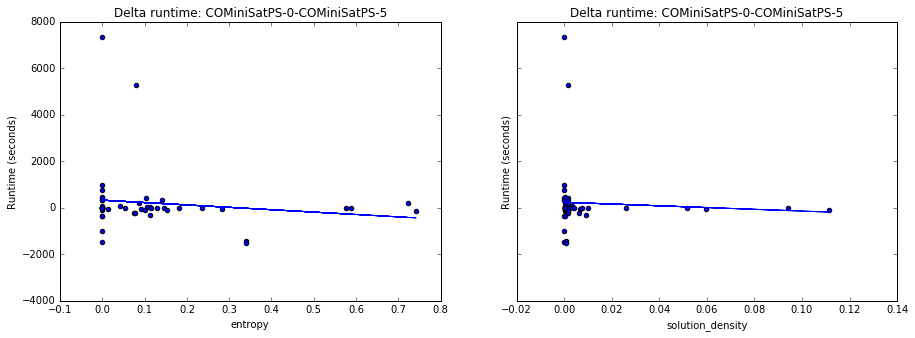

In [21]:
plotter_entropy_sols_sharingy(df, 'exp2', formulas_set, 'COMiniSatPS-0', 'COMiniSatPS-5')

Same as before (but density trend is different)

# Exp3 - Saving criterion - Clause-size - Lbd

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


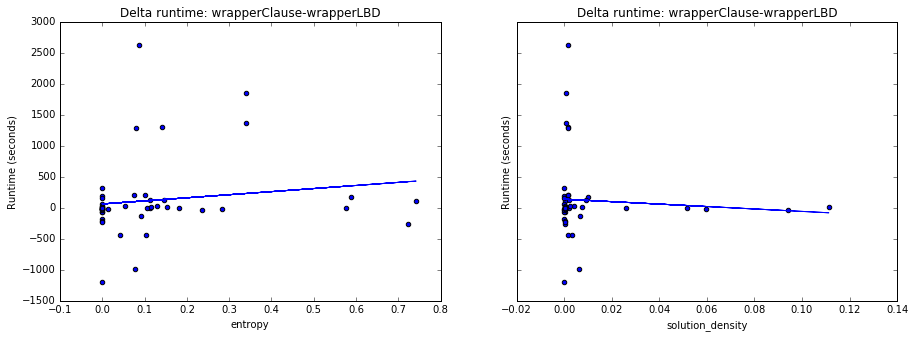

In [22]:
plotter_entropy_sols_sharingy(df, 'exp3', formulas_set, 'wrapperClause', 'wrapperLBD')

The variation is more significant with low entropy and low density. Trends aren't like our paper (but maybe it's early to decide)

# Exp4 - Restarts type (Luby - Glucose)

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


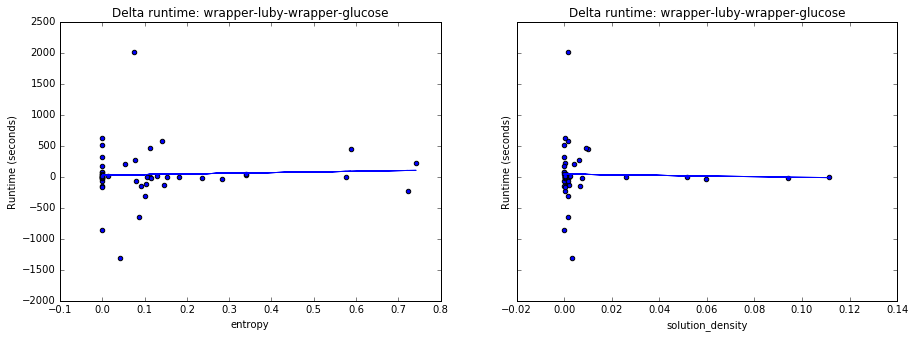

In [23]:
plotter_entropy_sols_sharingy(df, 'exp4', formulas_set, 'wrapper-luby', 'wrapper-glucose')

Same trend as our paper

# Exp5 - Variable decay factor (G0.6 - G0.95)

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


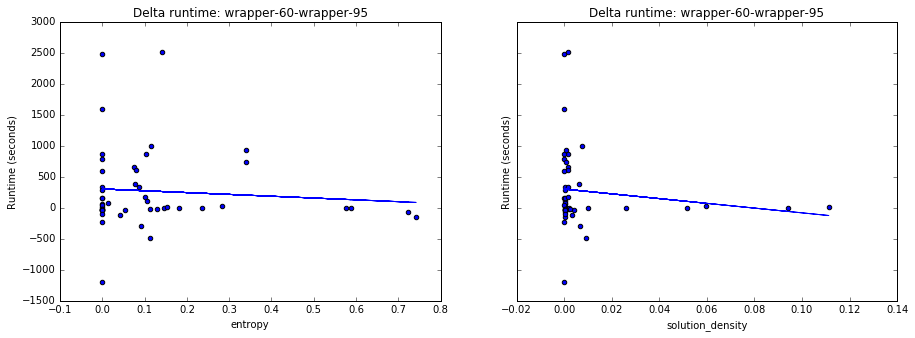

In [24]:
plotter_entropy_sols_sharingy(df, 'exp5', formulas_set, 'wrapper-60', 'wrapper-95')

For low entropy there's high variation, for high entropy the diff is low.

About density - same as our paper

# Summary

The trends aren't 100% same as our paper (but not that different), although we have more formulas to add (2016-2017) to our dataset

I think we should emphasize the large variation between the engines for low entropy, and small variation for high entropy. 

Why should we care about it? The entropy/solution density could be a new measure for the hardness of SATISFIABLE formulas. If for example we work in the industry on some kind of formula, we could run the entropy (solution density) approximator once to tell us if the formula has high or low entropy (solution density). Another scenario: tell something about the competitions formulas (do they have small entropy on average?).

TODO:
* We should filter formulas with runtime < 15 seconds (?)



## How large is the variation between all engines (for entropy/density < threshold)?

Global variation (all entropies)

In [25]:
print(df['entropy'].mean(), df['entropy'].std())

(0.119837395833333, 0.18574338385957628)


Low entropy

In [26]:
def threshold_mean_std(df, threshold, prop):
    print 'low %s' % prop
    print 'mean %lf, std %lf' % (df[df[prop] < threshold][prop].mean(),
                                 df[df[prop] < threshold][prop].std())
    print 'high %s' % prop
    print 'mean %lf, std %lf' % (df[df[prop] >= threshold][prop].mean(),
                                 df[df[prop] >= threshold][prop].std())

In [27]:
for thres in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print 'threshold: %lf' % thres
    threshold_mean_std(df, thres, 'entropy')
    print

threshold: 0.100000
low entropy
mean 0.017936, std 0.031718
high entropy
mean 0.275370, std 0.213576

threshold: 0.200000
low entropy
mean 0.048037, std 0.057289
high entropy
mean 0.478840, std 0.189637

threshold: 0.300000
low entropy
mean 0.058147, std 0.072104
high entropy
mean 0.551673, std 0.162687

threshold: 0.400000
low entropy
mean 0.070946, std 0.091686
high entropy
mean 0.657645, std 0.075923

threshold: 0.500000
low entropy
mean 0.070946, std 0.091686
high entropy
mean 0.657645, std 0.075923

threshold: 0.600000
low entropy
mean 0.093191, std 0.137620
high entropy
mean 0.732713, std 0.009631

threshold: 0.700000
low entropy
mean 0.093191, std 0.137620
high entropy
mean 0.732713, std 0.009631

threshold: 0.800000
low entropy
mean 0.119837, std 0.185743
high entropy
mean nan, std nan



Notice how the standard deviation is increasing for low entropy and decreasing for high entropy, as we increase the threshold.

In [28]:
for thres in [0.01, 0.05, 0.1, 0.15, 0.2]:
    print 'threshold: %lf' % thres
    threshold_mean_std(df, thres, 'solution_density')
    print

threshold: 0.010000
low solution_density
mean 0.001403, std 0.002215
high solution_density
mean 0.058803, std 0.035539

threshold: 0.050000
low solution_density
mean 0.002156, std 0.004409
high solution_density
mean 0.079221, std 0.024591

threshold: 0.100000
low solution_density
mean 0.006393, std 0.017418
high solution_density
mean 0.111300, std 0.000000

threshold: 0.150000
low solution_density
mean 0.008578, std 0.022843
high solution_density
mean nan, std nan

threshold: 0.200000
low solution_density
mean 0.008578, std 0.022843
high solution_density
mean nan, std nan



Same goes for solution density, although we don't have much diversity in its values.